In [27]:
import pandas as pd
import numpy as np
import time
import pickle
from tqdm import tqdm
tqdm.pandas()
from wikidata.client import Client

# ImDB ID search

In [28]:
# load author information
data_path = "/zfs/projects/faculty/amirgo-management/opus/processed/"
df_full = pd.read_pickle(data_path+"total_parsed_df.pkl")
df_meta = df_full[['SubtitleID', 'imdbID', 'Year', 'metadata']].copy()
del df_full

In [29]:
df_meta['subtitle_date'] = df_meta['metadata'].apply(lambda x: x['subtitle']['date'] if 'date' in x['subtitle'] else None)
df_meta['if_machine_translated'] = df_meta['metadata'].apply(lambda x: x['subtitle']['machine_translated'] if 'machine_translated' in x['subtitle'] else None)
df_meta['source_date'] = df_meta['metadata'].apply(lambda x: int(x['source']['year']) if 'year' in x['source'] else None)
df_meta['subtitle_date'] = df_meta['subtitle_date'].apply(lambda x: int(x.split('-')[0]) if x is not None else None)
df_meta['date_gap'] = df_meta['subtitle_date'] - df_meta['source_date']
df_meta = df_meta[df_meta['date_gap'] >=-1]

In [30]:
imdb_path = "/zfs/projects/faculty/amirgo-management/imdb/"
imdb_crew = pd.read_csv(imdb_path+"title.crew.tsv", sep='\t')
total_ids = imdb_crew['tconst'].unique()
df_meta['imdbID_tt'] = df_meta['imdbID'].apply(lambda x: 'tt'+str(x).zfill(7))
df_meta['imdb_match'] = df_meta['imdbID_tt'].isin(total_ids)
df_meta = df_meta.merge(imdb_crew, left_on='imdbID_tt', right_on='tconst', how='left')
df_meta['writers'] = df_meta['writers'].astype(str)
df_meta['writers'] = df_meta['writers'].apply(lambda x: x.split(',') if x!="\\N" else [])
df_meta['directors'] = df_meta['directors'].astype(str)
df_meta['directors'] = df_meta['directors'].apply(lambda x: x.split(',') if x!="\\N" else [])

In [49]:
1- df_meta[df_meta['imdb_match']==False]['imdbID'].nunique()/df_meta['imdbID'].nunique()

0.9987540973880542

In [8]:
df_meta.to_pickle(data_path+"metadata_df.pkl")

## Query IMDB in wikidata

In [2]:
from SPARQLWrapper import SPARQLWrapper, JSON

In [ ]:
# number of unique writers
data_path = "/zfs/projects/faculty/amirgo-management/opus/processed/"
df_meta = pd.read_pickle(data_path+"metadata_df.pkl")
# df_meta['directors'] = df_meta['directors'].astype(str)
# df_meta['directors'] = df_meta['directors'].apply(lambda x: x.split(',') if x!="\\N" else [])
total_writers = list(df_meta['writers'].explode().unique()) #65666
total_directors = list(df_meta['directors'].explode().unique())
total_imdb_ids = list(set(total_writers + total_directors))

In [10]:
print("Total imdb ids to be queries: ", len(total_imdb_ids))

Total imdb ids to be queries:  80102


In [11]:
def match_imdb_to_wikidata(imdb_ids):
    # Initialize SPARQL endpoint
    sparql = SPARQLWrapper("https://query.wikidata.org/sparql")
    
    # Construct SPARQL query
    imdb_values = " ".join(f'"{imdb_id}"' for imdb_id in imdb_ids)
    query = f"""
    SELECT ?entity ?entityLabel ?imdb WHERE {{
      VALUES ?imdb {{ {imdb_values} }}  # IMDb IDs to match
      ?entity wdt:P345 ?imdb.
      SERVICE wikibase:label {{ bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }}
    }}
    """
    
    # Set query and return format
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    
    # Execute query
    results = sparql.query().convert()
    
    # Process results
    matches = []
    for result in results["results"]["bindings"]:
        matches.append({
            "imdb_id": result["imdb"]["value"],
            "wikidata_entity": result["entity"]["value"],
            "label": result.get("entityLabel", {}).get("value", "Unknown")
        })
    
    return matches

In [23]:
# Process IMDb IDs in chunks
chunk_size = 100
all_matches = []
chunks = np.array_split(total_imdb_ids, len(total_imdb_ids) // chunk_size + 1)

# Process IMDb IDs in chunks with tqdm
all_matches = []
for chunk in tqdm(chunks, desc="Processing IMDb Chunks"):
    matches = match_imdb_to_wikidata(chunk.tolist())  # Convert NumPy array to list
    all_matches.extend(matches)
    time.sleep(1)  # Sleep for 1 second to avoid hitting the Wikidata API too quickly

# Convert to DataFrame
df_matches = pd.DataFrame(all_matches)
df_matches.to_pickle(data_path+"imdb_wikidata_person_mapping.pkl")

Processing IMDb Chunks: 100%|██████████| 802/802 [16:48<00:00,  1.26s/it]


In [ ]:
df_matches['wikidata_id'] = df_matches['wikidata_entity'].apply(lambda x: x.split('/')[-1])
del df_matches['wikidata_entity']
df_matches.to_pickle(data_path+"imdb_wikidata_person_mapping.pkl")

In [ ]:
data_path = "/zfs/projects/faculty/amirgo-management/opus/processed/"
df_matches = pd.read_pickle(data_path+"imdb_wikidata_person_mapping.pkl")
matched = list(set(df_matches['imdb_id']).intersection(set(total_writers)))
print("Matched writers: ", len(matched), "In ", len(total_writers))

Matched writers:  36160 In  65666


# Person to be Queryed

In [3]:
def property_value_extraction(entity, prop):
    claims = entity.data.get('claims', {})
    property_claims = claims.get(prop, []) # usually start with p
    values = []
    for claim in property_claims:
        mainsnak = claim.get('mainsnak', {})
        datavalue = mainsnak.get('datavalue', {})
        value = datavalue.get('value', {}).get('id', None)
        if value:
            values.append(value)
    return values

def time_extraction(entity, prop):
    claims = entity.data.get('claims', {})
    property_claims = claims.get(prop, []) # usually start with p
    values = []
    for claim in property_claims:
        mainsnak = claim.get('mainsnak', {})
        datavalue = mainsnak.get('datavalue', {})
        value = datavalue.get('value', {}).get('time', None)
        if value:
            values.append(value)
    return values

# sometimes, education information is nested
def get_education(entity):
    # if degree or major is nested in education
    institution_values = []
    degree_values = []
    major_values = []

    claims = entity.data.get('claims', {})
    education_claims = claims.get('P69', []) # usually start with p
    for education in education_claims:
        # main entry: institution
        mainsnak = education.get('mainsnak', {})
        datavalue = mainsnak.get('datavalue', {})
        value = datavalue.get('value', {}).get('id', None)
        if value:
            institution_values.append(value)
        # search qualifiers for degree and major, in case they are nested
        qualifiers = education.get('qualifiers', {})
        if "P512" in qualifiers:
            degree_id = qualifiers["P512"][0].get('datavalue', {}).get('value', {}).get('id')
            degree_values.append(degree_id)
        if "P812" in qualifiers:
            major_id = qualifiers["P812"][0].get('datavalue', {}).get('value', {}).get('id')
            major_values.append(major_id)
    
    # search for degree and major if they are not nested
    degree_values += property_value_extraction(entity, 'P512')
    major_values += property_value_extraction(entity, 'P812')

    # remove duplicates
    institution_values = list(set(institution_values))
    degree_values = list(set(degree_values))
    major_values = list(set(major_values))

    return institution_values, degree_values, major_values    

def get_SES_characteristics(entity):
    # gender
    gender_values = property_value_extraction(entity, 'P21')
    # birth date
    birth_date_values = time_extraction(entity, 'P569')
    # death date
    death_date_values = time_extraction(entity, 'P570')
    # citizenship
    citizenship_values = property_value_extraction(entity, 'P27')
    # ethinic group
    ethinic_group_values = property_value_extraction(entity, 'P172')
    # education
    education_values, degree_values, major_values = get_education(entity)
    # student of (this will be sparse) -- if students of famous economists are included, this will be useful
    student_of_values = property_value_extraction(entity, 'P1066')
    # occupation
    occupation_values = property_value_extraction(entity, 'P106')
    # employer in the past
    employer_values = property_value_extraction(entity, 'P108')
    # political party (this will be sparse)
    political_party_values = property_value_extraction(entity, 'P102')
    # ideology (this will be sparse)
    ideology_values = property_value_extraction(entity, 'P1142')

    # dictionary
    SES_characteristics = {"gender": gender_values, "birth_date": birth_date_values, "death_date": death_date_values,
                            "citizenship": citizenship_values, "ethinic_group": ethinic_group_values, "education": education_values,
                            "degree": degree_values,"major": major_values, "student_of": student_of_values, "occupation": occupation_values,
                            "employer": employer_values, "political_party": political_party_values, "ideology": ideology_values}
    return SES_characteristics

In [4]:
# total entities to be queried
data_path = "/zfs/projects/faculty/amirgo-management/opus/processed/"
df_matches = pd.read_pickle(data_path+"imdb_wikidata_person_mapping.pkl")
print("Number of unique people: ", len(df_matches["wikidata_id"].unique()))
total_qids = df_matches["wikidata_id"].unique()

Number of unique people:  44826


In [ ]:
# for each entity, get SES characteristics
client = Client()
total_ses_characteristics = []
error_qids = []
for qid in tqdm(total_qids):
    try:
        entity = client.get(qid, load=True)
        SES_characteristics = get_SES_characteristics(entity)
        SES_characteristics["qid"] = qid
        total_ses_characteristics.append(SES_characteristics)
        # wait for 0.2 second
        time.sleep(0.2)
    except:
        print("Error: ", qid)
        error_qids.append(qid)
        time.sleep(30) # wait for 30 seconds

  1%|          | 261/44826 [01:55<5:35:35,  2.21it/s]

Error:  Q90212


In [ ]:
# save the SES characteristics
ses_df = pd.DataFrame(total_ses_characteristics)
ses_df.to_pickle(data_path + "opus_ses_characteristics.pkl")

# QID to label

In [11]:
from SPARQLWrapper import SPARQLWrapper, JSON

In [17]:
data_path = "/zfs/projects/faculty/amirgo-management/opus/processed/"
ses_df = pd.read_pickle(data_path + "opus_ses_characteristics.pkl")
fiction_ses = pd.read_pickle("/zfs/projects/faculty/amirgo-management/HathiTrust/fiction_ses_characteristics.pkl")
congress_ses = pd.read_pickle("/zfs/projects/faculty/amirgo-management/congress/congress_ses_characteristics.pkl")

In [ ]:
list(set(ses_df['education'].sum()))

In [18]:
# convert all qids in columns to its corresponding label
def all_qids_to_label(ses_df):
    gender_qids = list(set(ses_df['gender'].sum()))
    citizenship_qids = list(set(ses_df['citizenship'].sum()))
    ethinic_group_qids = list(set(ses_df['ethinic_group'].sum()))
    education_qids = list(set(ses_df['education'].sum()))
    degree_qids = list(set(ses_df['degree'].sum()))
    major_qids = list(set(ses_df['major'].sum()))
    student_of_qids = list(set(ses_df['student_of'].sum()))
    occupation_qids = list(set(ses_df['occupation'].sum()))
    employer_qids = list(set(ses_df['employer'].sum()))
    political_party_qids = list(set(ses_df['political_party'].sum()))
    ideology_qids = list(set(ses_df['ideology'].sum()))

    total_qids = gender_qids + citizenship_qids + ethinic_group_qids + education_qids + degree_qids + major_qids + student_of_qids + occupation_qids + employer_qids + political_party_qids + ideology_qids
    return total_qids

In [22]:
opus_qids = all_qids_to_label(ses_df)
fiction_qids = all_qids_to_label(fiction_ses)
congress_qids = all_qids_to_label(congress_ses)
total_qids = list(set(opus_qids + fiction_qids + congress_qids))

In [23]:
len(opus_qids), len(fiction_qids), len(congress_qids), len(total_qids)

(12191, 9256, 3858, 16792)

In [25]:
def fetch_labels(qids):
    sparql = SPARQLWrapper("https://query.wikidata.org/sparql")
    labels = {}

    # Construct SPARQL query for the current batch
    qid_filter = " ".join([f"wd:{qid}" for qid in qids])
    query = f"""
    SELECT ?item ?itemLabel WHERE {{
        VALUES ?item {{ {qid_filter} }}
        SERVICE wikibase:label {{ bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }}
    }}
    """
    
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    
    try:
        # Execute the query
        results = sparql.query().convert()
        
        # Parse results
        for result in results["results"]["bindings"]:
            qid = result["item"]["value"].split("/")[-1]  # Extract QID from full URI
            label = result["itemLabel"]["value"]  # Extract the label
            labels[qid] = label
    
    except Exception as e:
        print(f"Error processing chunk: {chunk}. Error: {e}")
    
    return labels

In [27]:
# Process QIDs in chunks
chunk_size = 100
all_labels = {}
chunks = np.array_split(total_qids, len(total_qids) // chunk_size + 1)

for chunk in tqdm(chunks, desc="Processing QID Chunks"):
    labels = fetch_labels(chunk.tolist())  # Convert NumPy array to list
    all_labels.update(labels)
    time.sleep(1)  # Sleep for 1 second to avoid hitting the Wikidata API too quickly

Processing QID Chunks: 100%|██████████| 168/168 [03:44<00:00,  1.33s/it]


In [28]:
# Save label dictionary
with open(data_path + "qid_to_label.pkl", "wb") as f:
    pickle.dump(all_labels, f)

In [40]:
# apply the label to the SES characteristics
data_path = "/zfs/projects/faculty/amirgo-management/opus/processed/"
ses_df = pd.read_pickle(data_path + "opus_ses_characteristics.pkl")
qid_to_label_dict = all_labels

In [41]:
ses_df['gender'] = ses_df['gender'].apply(lambda x: [qid_to_label_dict[qid] for qid in x if qid!=None])
ses_df['citizenship'] = ses_df['citizenship'].apply(lambda x: [qid_to_label_dict[qid] for qid in x if qid!=None])
ses_df['ethinic_group'] = ses_df['ethinic_group'].apply(lambda x: [qid_to_label_dict[qid] for qid in x if qid!=None])
ses_df['education'] = ses_df['education'].apply(lambda x: [qid_to_label_dict[qid] for qid in x if qid!=None])
ses_df['degree'] = ses_df['degree'].apply(lambda x: [qid_to_label_dict[qid] for qid in x if qid!=None])
ses_df['major'] = ses_df['major'].apply(lambda x: [qid_to_label_dict[qid] for qid in x if qid!=None])
ses_df['student_of'] = ses_df['student_of'].apply(lambda x: [qid_to_label_dict[qid] for qid in x if qid!=None])
ses_df['occupation'] = ses_df['occupation'].apply(lambda x: [qid_to_label_dict[qid] for qid in x if qid!=None])
ses_df['employer'] = ses_df['employer'].apply(lambda x: [qid_to_label_dict[qid] for qid in x if qid!=None])
ses_df['political_party'] = ses_df['political_party'].apply(lambda x: [qid_to_label_dict[qid] for qid in x if qid!=None])
ses_df['ideology'] = ses_df['ideology'].apply(lambda x: [qid_to_label_dict[qid] for qid in x if qid!=None])

In [43]:
ses_df.to_pickle(data_path + "opus_ses_characteristics_labelled.pkl")

# Key Indicator Extraction

### education class query
- for education institution, if the name "university/college" is not in the label, run additional query to check if it is a university/college
    - instance of 
    - subclass of university (Q3918), or higher education institution (Q38723)
    - part of 
    - industry : higher education: Q136822
    - optional: report times higher education id P5586, P5584
- also determine if a school is a business school: Q1143635, or a degree is MBA: Q191701

In [85]:
data_path = "/zfs/projects/faculty/amirgo-management/opus/processed/"
bschools = pd.read_csv(data_path+"business_schools.csv")
ses_df = pd.read_pickle(data_path + "opus_ses_characteristics.pkl")
ses_df_labelled = pd.read_pickle(data_path + "opus_ses_characteristics_labelled.pkl")
bschools['qid'] = bschools['business_school'].apply(lambda x: x.split('/')[-1])

In [86]:
# business education
# if someone went to business school: if education institution is in the list of business schools; or if degree is business
business_degree = set(['Q798129', 'Q12580940','Q191701'])
business_schools = set(bschools['qid'].tolist())
def if_biz_ed(row):
    education = row['education']
    degree = row['degree']
    if len(education) == 0 and len(degree) == 0:
        return "Missing"
    else:
        if_biz = False
        for edu in education:
            if edu in business_schools:
                if_biz = True
                break
        for deg in degree:
            if deg in business_degree:
                if_biz = True
                break
        return str(if_biz)

ses_df['if_business_ed'] = ses_df.apply(lambda x: if_biz_ed(x), axis=1)

In [87]:
# college education (a corse classification)
# if the education institution has 'university' or 'college' in the name;
college_degrees = ['bachelor', 'master', 'doctor', 'phd', 'ba', 'ma', 'bs', 'ms', 'mba', 'jd', 'llb', 'llm', 'md']
def if_college_ed(row):
    education = row['education']
    degree = row['degree']
    if len(education) == 0 and len(degree) == 0:
        return "Missing"
    else:
        if_college = False
        for edu in education:
            if 'university' in edu.lower() or 'college' in edu.lower():
                if_college = True
                break
        for deg in degree:
            deg = deg.lower()
            if any(col in deg for col in college_degrees):
                if_college = True
                break
        return str(if_college)

ses_df_labelled['if_college_ed'] = ses_df_labelled.apply(lambda x: if_college_ed(x), axis=1)

In [88]:
# business occupation
occupations = ['businessperson','business executive','entrepreneur', 'businessman', 'business',
 'investor', 'executive', 'ceo', 'banker','manager', 'consultant','chief executive officer', 'finance', 'managing', 'executive','investment']

def if_bis_occuptation(row):
    occupation = row['occupation']
    if len(occupation) == 0:
        return "Missing"
    else:
        if_bis = False
        for occ in occupation:
            occ = occ.lower()
            for x in occupations:
                if x in occ:
                    if_bis = True
                    break
        return str(if_bis)

ses_df_labelled['if_business_occupation'] = ses_df_labelled.apply(lambda x: if_bis_occuptation(x), axis=1)

In [89]:
ses_df_labelled['if_business_ed']  =ses_df['if_business_ed'] 

In [90]:
ses_df_labelled.to_pickle(data_path + "opus_ses_characteristics_labelled.pkl")

In [91]:
# def convert gender to string
def convert_gender(ls):
    if len(ls) == 0:
        return 'Missing'
    elif len(ls) == 1:
        if ls[0] == 'male' or ls[0] == 'female':
            return ls[0]
        else:
            return "Other"
    else:
        return "Other"


ses_df_labelled['gender_str'] = ses_df_labelled['gender'].apply(lambda x: convert_gender(x))
ses_df_labelled['birth_date'] = ses_df_labelled['birth_date'].apply(lambda x: x[0] if len(x) > 0 else "Missing")
ses_df_labelled['birth_year'] = ses_df_labelled['birth_date'].apply(lambda x: int(x[1:5]) if x != "Missing" else "Missing")
ses_df_labelled[['qid','birth_year','gender_str','if_college_ed','if_business_occupation','if_business_ed']].to_csv(data_path + "opus_ses_characteristics_labelled_subset.csv", index=False)

In [92]:
ses_df_labelled[['qid','birth_year','gender_str','if_college_ed','if_business_occupation','if_business_ed']]

,qid,birth_year,gender_str,if_college_ed,if_business_occupation,if_business_ed
0,Q1151,1803,male,False,False,False
1,Q219377,1965,male,True,False,False
2,Q6175864,1969,male,True,False,False
3,Q7857085,1976,male,Missing,False,Missing
4,Q16204332,Missing,female,Missing,False,Missing
...,...,...,...,...,...,...
44818,Q117854262,Missing,male,Missing,False,Missing
44819,Q117860654,Missing,male,Missing,False,Missing
44820,Q118692478,Missing,male,Missing,False,Missing
44821,Q77811903,1956,male,Missing,False,Missing


In [ ]:
data_path = "/zfs/projects/faculty/amirgo-management/opus/processed/"
df_meta = pd.read_pickle(data_path+"metadata_df.pkl")
total_writers = list(df_meta['writers'].explode().unique()) #65666
df_matches = pd.read_pickle(data_path+"imdb_wikidata_person_mapping.pkl")
matched = list(set(df_matches['imdb_id']).intersection(set(total_writers)))
matched_qids = list(df_matches[df_matches['imdb_id'].isin(matched)]['wikidata_id'].unique())

In [93]:
ses_writer = ses_df_labelled[ses_df_labelled['qid'].isin(matched_qids)]

In [97]:
ses_writer.shape[0] - ses_writer['birth_year'].value_counts()['Missing']

np.int64(29754)

In [98]:
ses_writer.shape[0] - ses_writer['gender_str'].value_counts()['Missing']

np.int64(35110)

In [100]:
ses_writer.shape[0] - ses_writer['if_college_ed'].value_counts()['Missing']

np.int64(14598)

In [101]:
ses_writer.shape[0] - ses_writer['if_business_occupation'].value_counts()['Missing']

np.int64(35985)

# Check label distribution

In [18]:
from matplotlib import pyplot as plt

In [16]:
ses_df_labelled = pd.read_pickle(data_path + "opus_ses_characteristics_labelled.pkl")

In [25]:
def freq_by_birthyear(col, df):
    # drop duplicates
    df = df.drop_duplicates(subset=['qid'])
    df = df[df['birth_year']>=1900]
    freq = df.groupby('birth_year')[col].value_counts().unstack()
    freq = freq.div(freq.sum(axis=1), axis=0)
    plt.bar(freq.index, freq[True])
    plt.xlabel('Year')
    plt.ylabel('Proportion')

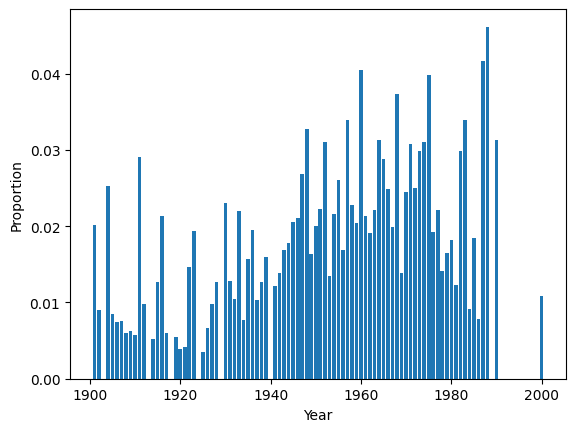

In [26]:
freq_by_birthyear('if_business_occupation', ses_df_labelled)

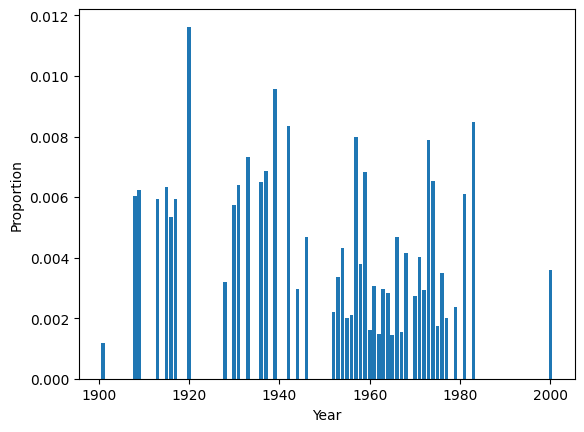

In [27]:
freq_by_birthyear('if_business_ed', ses_df_labelled)

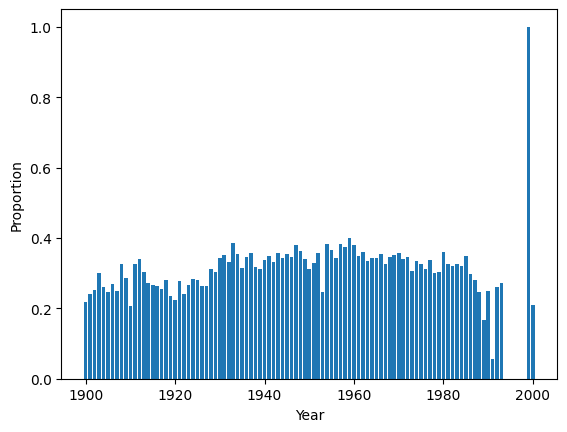

In [28]:
freq_by_birthyear('if_college_ed', ses_df_labelled)

## implicit with time